# Flight Price Prediction model developing

---

This project is for estimating Fare or Air Ticket based on real data scenario. 

In [1]:
# Importing necessary modules
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline

In [2]:
# dataset is in form of excel file in github
# so link will be added by '?raw=true'
url = 'https://github.com/mdimran1/Dataset/blob/main/Flight%20Fare/Data_Train.xlsx?raw=true'
AirFare = pd.read_excel(url)

# set fow all column display
pd.set_option('display.max_columns', None)

In [3]:
AirFare.head()  # data summery 

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
AirFare.info() # Description Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
# checking null value:
AirFare.isnull().any()
AirFare.isnull().sum()

AirFare[AirFare['Route'].isnull()]
# ! records has null in both Route & Total_Stops column, so we might remove this records
AirFare.dropna(axis=0, inplace=True)     

## Feature extracting

From description we notice Date_of_Journey is a object data type, so we have to convert this datatype into timestamp so as to use this column properly for extracting

In [6]:
# extracting day from .dt method
AirFare["Journey_day"] = pd.to_datetime(AirFare.Date_of_Journey, format="%d/%m/%Y").dt.day

# Extracting month from .dt method
AirFare["Journey_month"] = pd.to_datetime(AirFare["Date_of_Journey"], format = "%d/%m/%Y").dt.month

# droping Date_of_Journey column:
AirFare.drop(['Date_of_Journey'],axis=1, inplace=True)

In [7]:
# Departure time is when airbus leave airport
# we extract departure hours and Minutes from Dep_Time for best uses for algorithm

# Extracting Hours
AirFare["Dep_hour"] = pd.to_datetime(AirFare["Dep_Time"]).dt.hour

# Extracting Minutes
AirFare["Dep_min"] = pd.to_datetime(AirFare["Dep_Time"]).dt.minute

# drop Dep_Time as it is of no use
del AirFare['Dep_Time']

In [8]:

# Arrival time is when the plane pulls up to the gate.
# Similar to Dep_time we extract Hours & Minutes from Arrival_Time

# Extracting Hours
AirFare["Arrival_hour"] = pd.to_datetime(AirFare.Arrival_Time).dt.hour

# Extracting Minutes
AirFare["Arrival_min"] = pd.to_datetime(AirFare.Arrival_Time).dt.minute

# Now we can drop Arrival_Time as it is of no use
AirFare.drop(["Arrival_Time"], axis = 1, inplace = True)

In [9]:
# Duration means Total time from departuring to reaching
# some data is only in hours and some are only in minutes, we migh format in one formation as like 0h0m:

AirFare['Duration'].unique()
AirFare.loc[2:5,['Duration']]

,Duration
2,19h
3,5h 25m
4,4h 45m
5,2h 25m


In [10]:
# Transforming 'Duration' feature:
lengh = len(AirFare['Duration'])
duration = list(AirFare['Duration'])
for index in range(lengh):
  if 'h' in duration[index] and 'm' not in duration[index]:
    duration[index] = duration[index] + ' 0m'
  elif 'h' not in duration[index] and 'm' in duration[index]:
    duration[index] = '0h ' + duration[index] 
  else:
    pass

# reassinging 'Duration' column :
AirFare['Duration'] = duration


In [11]:
# Now we extract duration in minutes from Duration column :
AirFare['Duration_minutes'] = (pd.to_timedelta(AirFare['Duration']).dt.seconds // 60)

# droping Duration feature is not usable anymore :
AirFare.drop(["Duration"], axis = 1, inplace = True)

## Categorical Feature handling

In [12]:
# checking 'Airline', 'Source' & 'Destination' feature magnitudes :

print('Airline :')
print(AirFare.Airline.unique())
print('#'*100)
print('Source :')
print(AirFare['Source'].unique())
print('#'*100)
print('Destination :')
print(AirFare['Destination'].unique())

# note: 'Airline', 'Source' & 'Destination' are Nomial Categorical data.
# we might use OneHotEncoding for usability for machine learning
# correction : 'New Delhi' & 'Delhi' probably the same location.

Airline :
['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']
####################################################################################################
Source :
['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']
####################################################################################################
Destination :
['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyderabad']


In [13]:
# replace 'New Delhi' with 'Delhi' 
AirFare['Destination'].replace('New Delhi', 'Delhi', inplace=True)

# OneHotEncoding for respective feature :

AirFare = pd.get_dummies(AirFare, columns=['Airline'])
AirFare = pd.get_dummies(AirFare, columns=['Source'])
AirFare = pd.get_dummies(AirFare, columns=['Destination'])

In [14]:
AirFare.iloc[:2,:]

,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_minutes,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata
0,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,170,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,445,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [15]:
AirFare.Additional_Info.value_counts(normalize=True)

# Note: 'Additional_Info' feature has 78% No info value, it is not necessary at all
# Route and Total_Stops are related to each other


No info                         0.781127
In-flight meal not included     0.185546
No check-in baggage included    0.029957
1 Long layover                  0.001779
Change airports                 0.000655
Business class                  0.000374
No Info                         0.000281
1 Short layover                 0.000094
Red-eye flight                  0.000094
2 Long layover                  0.000094
Name: Additional_Info, dtype: float64

In [16]:
# droping columns: 

AirFare.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

In [17]:
AirFare.Total_Stops.unique()

# As this is case of Ordinal Categorical type we perform LabelEncoder

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [18]:
# New values are assigned with corresponding keys for 'Total_Stops' :

replace_dict = {"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}
AirFare['Total_Stops'].replace(replace_dict, inplace=True)

In [19]:
# Rearrange features for best api ui :
AirFare.columns
AirFare= AirFare[['Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers', 'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet', 'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',       'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata','Total_Stops','Duration_minutes', 'Price']]

In [20]:
AirFare.head(2)

,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Total_Stops,Duration_minutes,Price
0,24,3,22,20,1,10,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,170,3897
1,1,5,5,50,13,15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,2,445,7662


In [21]:
AirFare.info()

# Take Down :  Data set is ready for further uses

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 31 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Journey_day                                10682 non-null  int64
 1   Journey_month                              10682 non-null  int64
 2   Dep_hour                                   10682 non-null  int64
 3   Dep_min                                    10682 non-null  int64
 4   Arrival_hour                               10682 non-null  int64
 5   Arrival_min                                10682 non-null  int64
 6   Airline_Air Asia                           10682 non-null  uint8
 7   Airline_Air India                          10682 non-null  uint8
 8   Airline_GoAir                              10682 non-null  uint8
 9   Airline_IndiGo                             10682 non-null  uint8
 10  Airline_Jet Airways                        106

## Feature Selection

In [22]:
# assign independent and dependent variables
X = AirFare.drop(labels=['Price'], axis=1)
y = AirFare['Price']

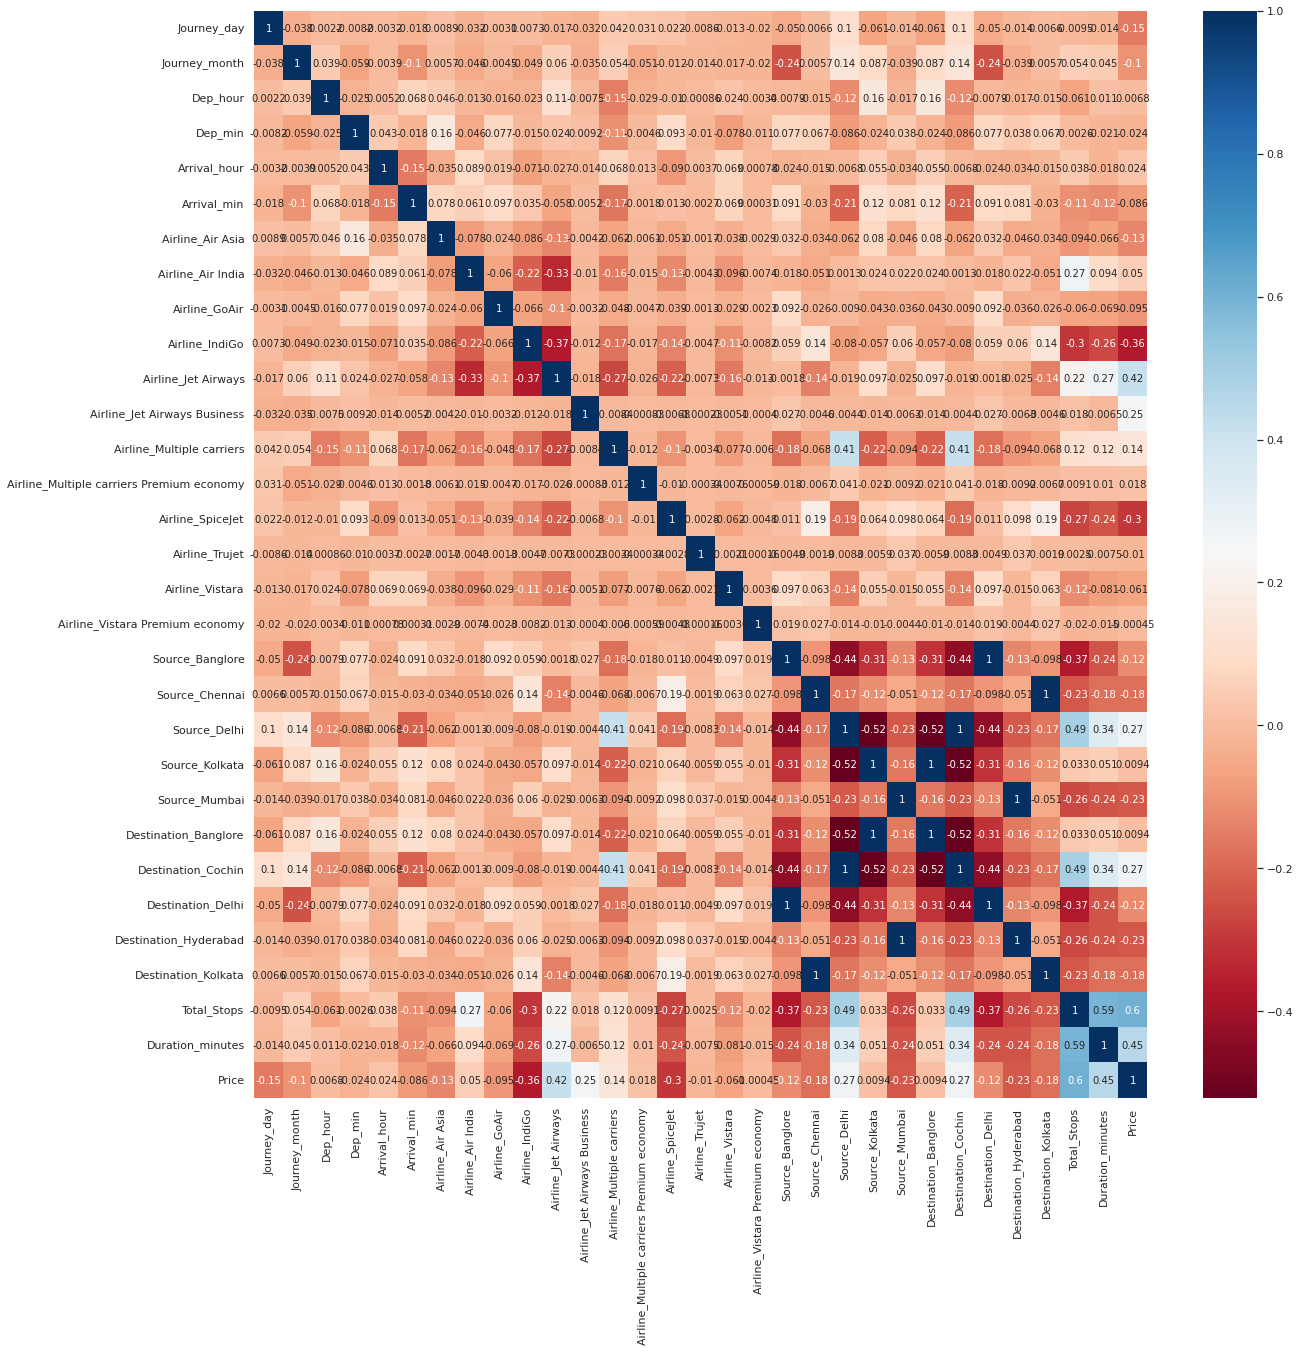

In [23]:
# ploting correlation of Features :
plt.figure(figsize=(20,20))
sns.heatmap(AirFare.corr(), annot = True, cmap='RdBu')

In [24]:
 # Most correalated features finding

from sklearn.ensemble import ExtraTreesRegressor 
select_feature = ExtraTreesRegressor().fit(X,y) #  fitting data

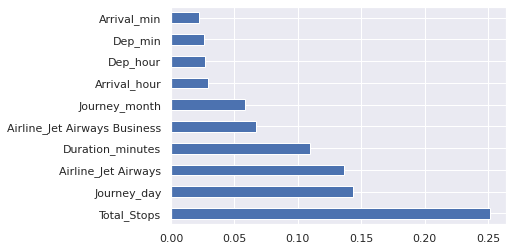

In [25]:
# Ploting top 10 most contributed feature :

feat_imp = pd.Series(select_feature.feature_importances_, index=X.columns)  # transform to pandas series for better understanding
#feat_imp.nlargest(10).plot(kind='barh')
feat_imp.sort_values(ascending=False)[:10].plot(kind='barh')

## Train Test spliting

In [26]:
# importing necessary modules :
from sklearn.model_selection import train_test_split  

# Spliting for model testing
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=12)

In [27]:
type(y_test)

pandas.core.series.Series

## Ridge model development

In [28]:
from sklearn.linear_model import Ridge
ridge = Ridge().fit(x_train, y_train) # fitting train data

# predicting Values
y_hat = ridge.predict(x_test)


In [29]:
# model metrics:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
print(f'R_Squared errors : {r2_score(y_test, y_hat)}')
print(f'Mean Squared Errors : {mse(y_test, y_hat)}')

R_Squared errors : 0.5912965452046584
Mean Squared Errors : 8681433.811469292


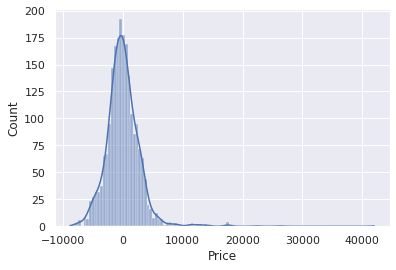

In [30]:
# Ploting model performance distribution :
sns.histplot(y_test- y_hat, kde=True)
plt.show()

## RandomForestRegressor

In [31]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(x_train, y_train) # fitting model
y_hat = reg_rf.predict(x_test) #prediction price


R_Squared errors : 0.8015343999022486
Mean Squared Errors : 4215687.31775203


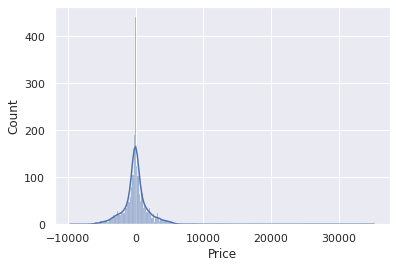

In [32]:
# evaluate model:
print(f'R_Squared errors : {r2_score(y_test, y_hat)}')
print(f'Mean Squared Errors : {mse(y_test, y_hat)}')


# Ploting model performance distribution :
sns.histplot(y_test- y_hat, kde=True)
plt.show()

## Lasso

In [33]:
from sklearn.linear_model import  Lasso
lasso = Lasso().fit(x_train, y_train) # fitting model

# prediction :
y_hat = lasso.predict(x_test)

R_Squared errors : 0.5922497756676544
Mean Squared Errors : 8661185.861337038


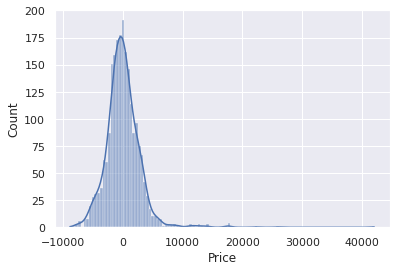

In [34]:
# evaluate model:
print(f'R_Squared errors : {r2_score(y_test, y_hat)}')
print(f'Mean Squared Errors : {mse(y_test, y_hat)}')


# Ploting model performance distribution :
sns.histplot(y_test- y_hat, kde=True)
plt.show()

## Hyperparameter tuning

**From above within three models RandomForestRegressor is fitted most prefectly and it's matrics is more positive than others.
<br> hyperparameter tuning for RandomForestRegressor can be more appropriate for us,
<br> So further we will focus on RandomForestRegressor model.**

In [35]:
# for fast and more suitable for RandomForestRegressor
# importing randomizedsearchcv 
from sklearn.model_selection import RandomizedSearchCV

In [36]:
# Value for tuning  RandomForestRegressor :

n_estimators = [x for x in range(10,1000,25)]
max_depth = [x for x in range(5,30,5)]
max_features= ['auto', 'sqrt', 'log2']

In [37]:
# making dictionery for passing Randomizedsearchcv :
parameters ={'n_estimators':n_estimators,
             'max_depth':max_depth,
             'max_features':max_features
             }

In [38]:
# Initializing RandomizedSearchCV :

random_rfg = RandomizedSearchCV(estimator=RandomForestRegressor(),param_distributions=parameters,scoring='neg_mean_absolute_error',n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [39]:
# fiting training data

random_rfg.fit(x_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...max_depth=5, max_features=log2, n_estimators=760; total time=   2.9s
[CV] END ...max_depth=5, max_features=log2, n_estimators=760; total time=   2.1s
[CV] END ...max_depth=5, max_features=log2, n_estimators=760; total time=   2.1s
[CV] END ...max_depth=5, max_features=log2, n_estimators=760; total time=   2.1s
[CV] END ...max_depth=5, max_features=log2, n_estimators=760; total time=   2.1s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=485; total time=   4.3s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=485; total time=   4.1s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=485; total time=   4.1s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=485; total time=   4.1s
[CV] END ..max_depth=20, max_features=sqrt, n_estimators=485; total time=   4.1s
[CV] END ..max_depth=25, max_features=log2, n_estimators=135; total time=   1.1s
[CV] END ..max_depth=25, max_features=log2, n_es

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [10, 35, 60, 85, 110,
                                                         135, 160, 185, 210,
                                                         235, 260, 285, 310,
                                                         335, 360, 385, 410,
                                                         435, 460, 485, 510,
                                                         535, 560, 585, 610,
                                                         635, 660, 685, 710,
                                                         735, ...]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [40]:
random_rfg.best_estimator_

RandomForestRegressor(max_depth=20, max_features='sqrt', n_estimators=485)

In [41]:
# Predicting test data :
y_hat = random_rfg.predict(x_test)

R_Squared errors : 0.7838673478438851
Mean Squared Errors : 4590960.248012108


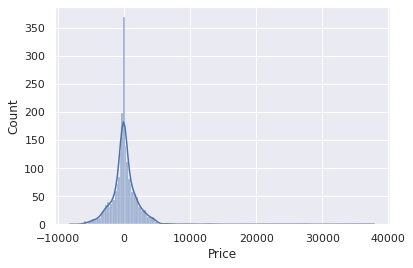

In [42]:
# evaluate model:
print(f'R_Squared errors : {r2_score(y_test, y_hat)}')
print(f'Mean Squared Errors : {mse(y_test, y_hat)}')


# Ploting model performance distribution :
sns.histplot(y_test- y_hat, kde=True)
plt.show()

## Save model for deployment/reuse

In [43]:
import pickle
# open a file, where you ant to store the data
file = open('price_model.pkl', 'wb')

# dump information to that file
pickle.dump(random_rfg, file) #random_rfg


# closing file 
file.close()

<center><p style="font-size:12">Thanks for reading </p></center>